The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

## Data Fields

- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

# Import libraries

In [103]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

import pandas as pd

import time

from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K

np.random.seed(0)
print ("OK")

OK


# EDA

## read data 'train.csv'

In [71]:
dataset = pd.read_csv("../data/train.csv") 

In [72]:
# Drop the first column 'Id' since it just has serial numbers. Not useful in the prediction process.
dataset = dataset.iloc[:,1:]

In [73]:
# Size of the dataframe

print(dataset.shape)

(15120, 55)


In [74]:
# Datatypes of the attributes

print(dataset.dtypes)

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

Data types of all attributes has been inferred as int64

In [75]:
# Statistical description

pd.set_option('display.max_columns', None)
print(dataset.describe())

          Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%            

Negative value(s) present in Vertical_Distance_To_Hydrology. Therefore, some tests such as chi-sq can't be used.
Wilderness_Area and Soil_Type are one hot encoded. Therefore, they could be converted back for some analysis.
Attributes Soil_Type7 and Soil_Type15 can be removed as they are constant.
Scales are not the same for all. Hence, rescaling and standardization may be necessary for some algorithms.

In [76]:
# Skewness of the distribution

print(dataset.skew())

Elevation                               0.075640
Aspect                                  0.450935
Slope                                   0.523658
Horizontal_Distance_To_Hydrology        1.488052
Vertical_Distance_To_Hydrology          1.537776
Horizontal_Distance_To_Roadways         1.247811
Hillshade_9am                          -1.093681
Hillshade_Noon                         -0.953232
Hillshade_3pm                          -0.340827
Horizontal_Distance_To_Fire_Points      1.617099
Wilderness_Area1                        1.231244
Wilderness_Area2                        5.228781
Wilderness_Area3                        0.324594
Wilderness_Area4                        0.825798
Soil_Type1                              6.294716
Soil_Type2                              4.617019
Soil_Type3                              3.575995
Soil_Type4                              3.872721
Soil_Type5                              9.416209
Soil_Type6                              4.506716
Soil_Type7          

Several attributes in Soil_Type show a large skew. Therefore, some algorithms may benefit if skew is corrected.

In [77]:
# Number of instances belonging to each class

dataset.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

We see that all classes have an equal presence. No class re-balancing is necessary

In [78]:
# set the number of features considered
size = 10 

# create a dataframe with only 'size' features
data = dataset.iloc[:,:size] 

# get the names of all the columns
cols = data.columns 

# Calculates pearson correlation co-efficient for all combinations
data_corr = data.corr()

# Set the threshold to select only highly correlated attributes
threshold = 0.5

# List of pairs along with correlation above threshold
corr_list = []

# Search for the highly correlated pairs
for i in range(0,size): # for 'size' features
    for j in range(i+1,size): # avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) # store correlation and columns index

# Sort to show higher ones first (absolute value)           
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

# Print correlations and column names above threshold
for v,i,j in s_corr_list:
    print ("{} and {} = {:.2f}".format(cols[i], cols[j], v))


Hillshade_9am and Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Aspect and Hillshade_3pm = 0.64
Hillshade_Noon and Hillshade_3pm = 0.61
Slope and Hillshade_Noon = -0.61
Aspect and Hillshade_9am = -0.59
Elevation and Horizontal_Distance_To_Roadways = 0.58


This represents an opportunity to reduce the feature set through transformations

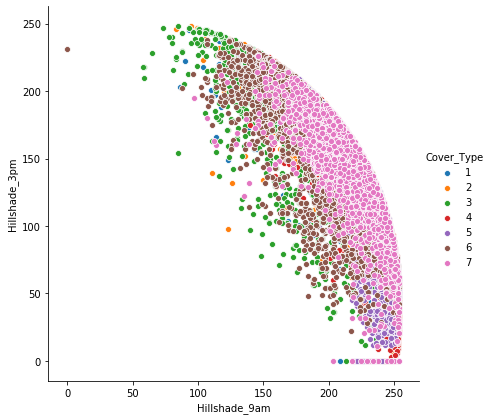

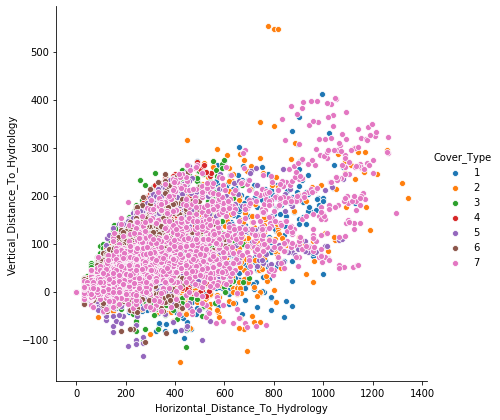

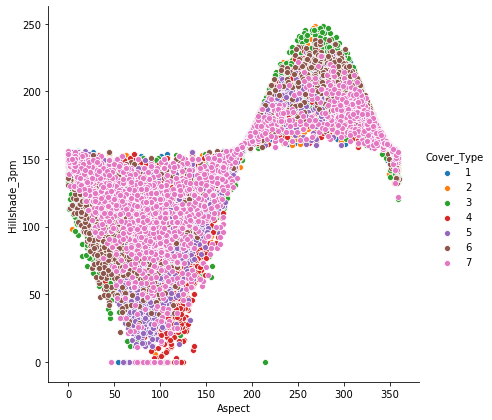

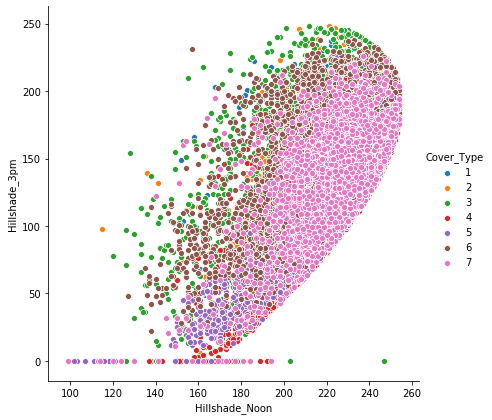

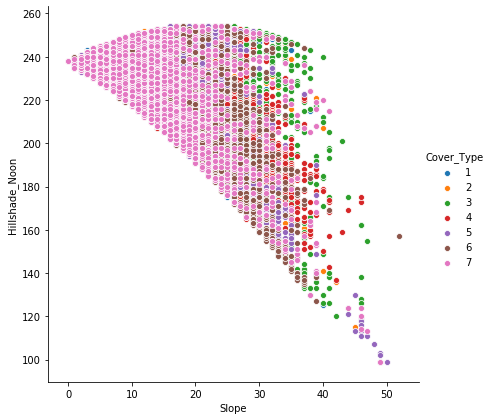

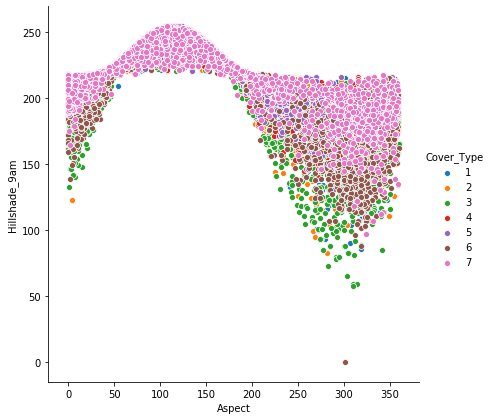

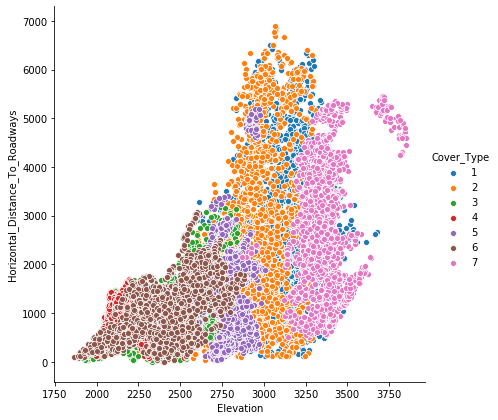

In [80]:
# Scatter plot of only the highly correlated pairs
for v,i,j in s_corr_list:
    sns.pairplot(dataset, hue="Cover_Type", size=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

The plots show which class does a point belong to. The class distribution overlaps in the plots.    
Hillshade patterns give a nice ellipsoid patterns with each other.
Aspect and Hillshades attributes form a sigmoid pattern.
Horizontal and vertical distance to hydrology give an almost linear pattern.

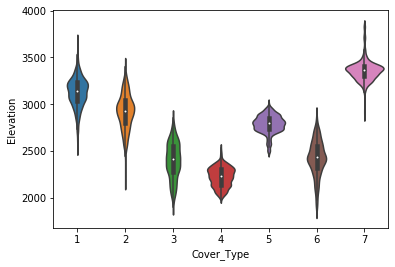

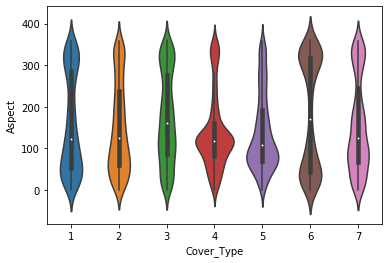

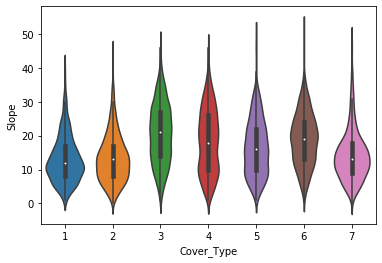

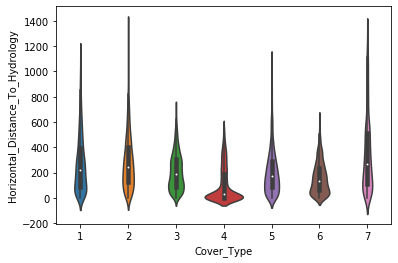

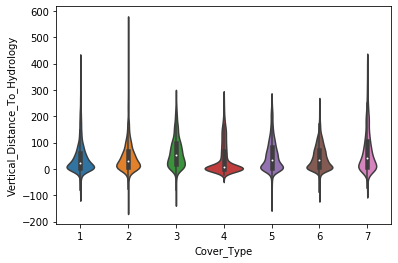

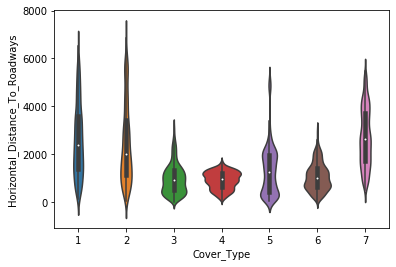

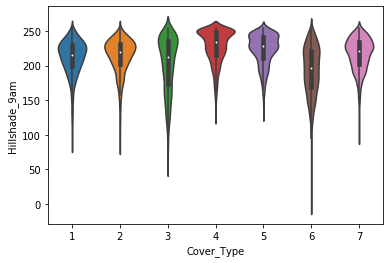

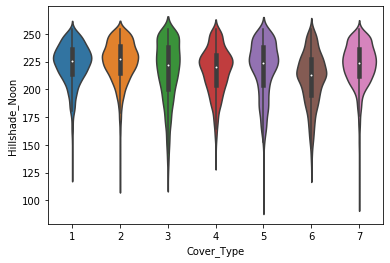

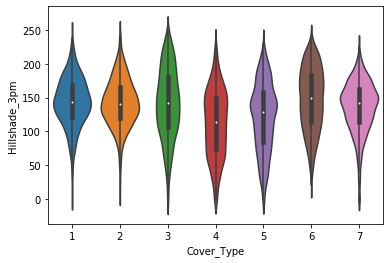

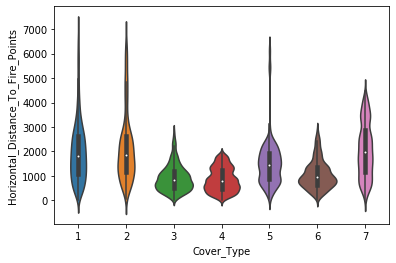

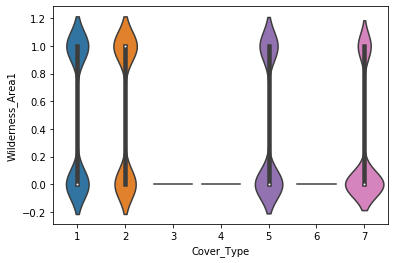

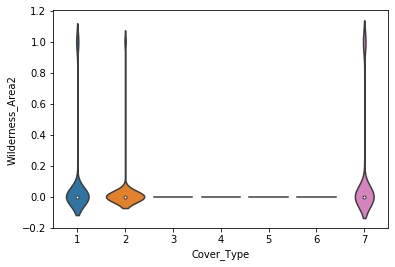

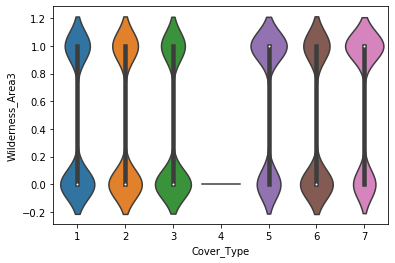

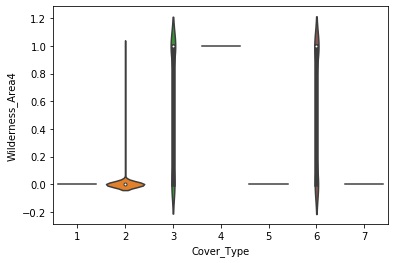

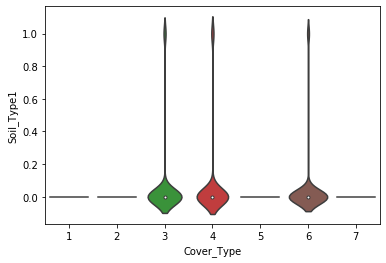

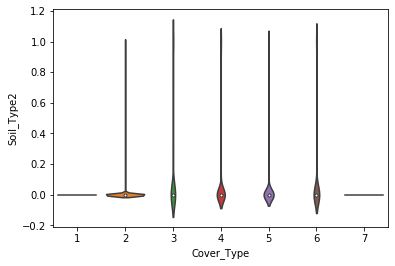

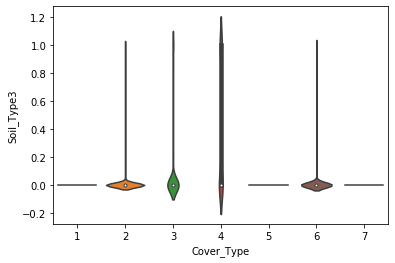

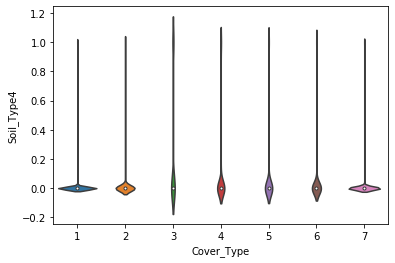

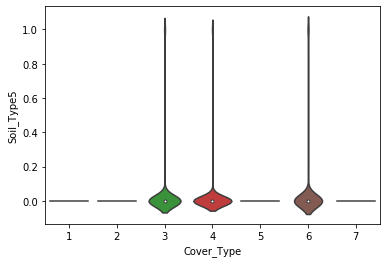

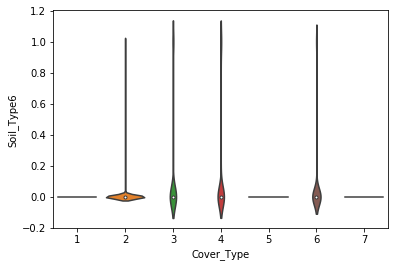

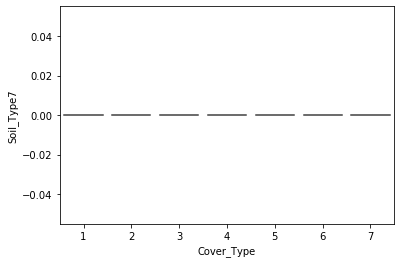

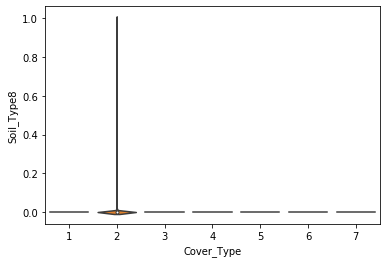

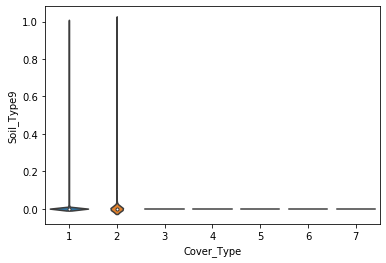

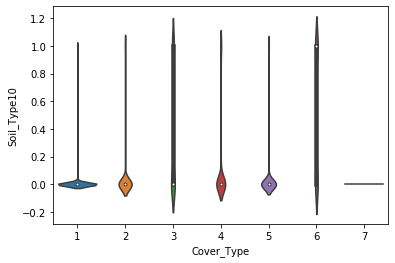

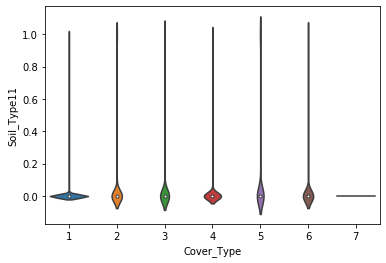

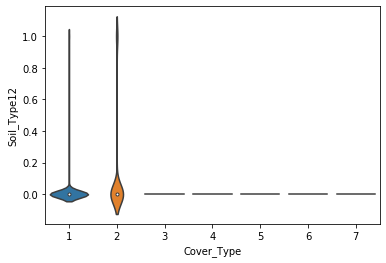

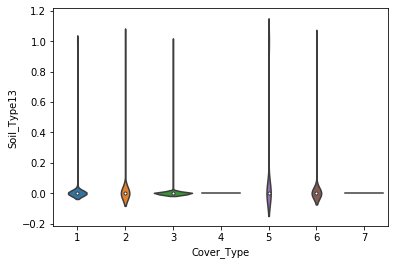

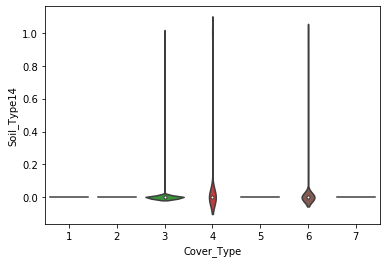

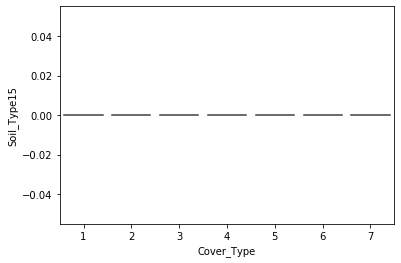

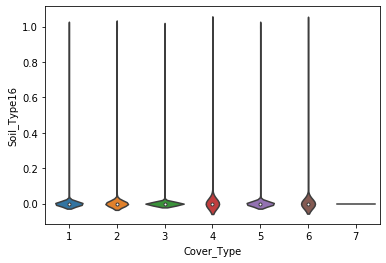

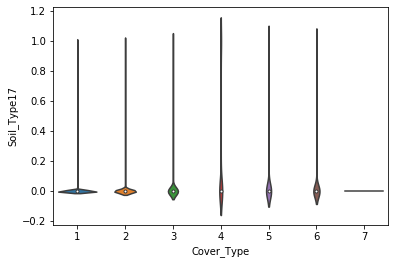

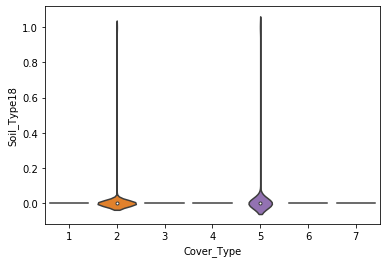

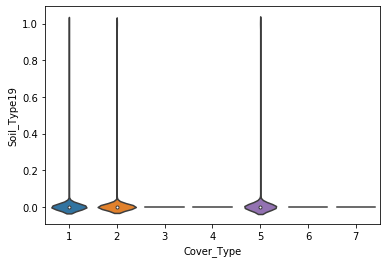

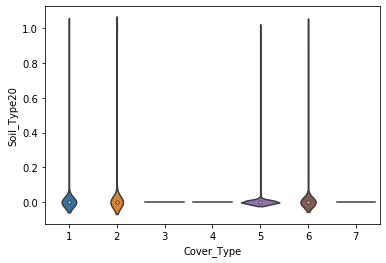

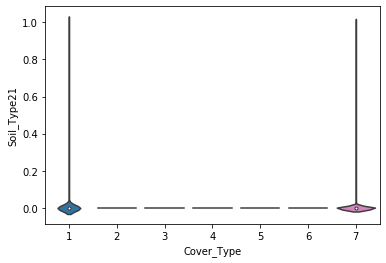

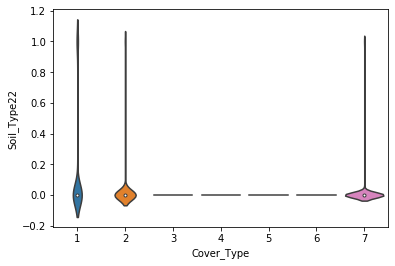

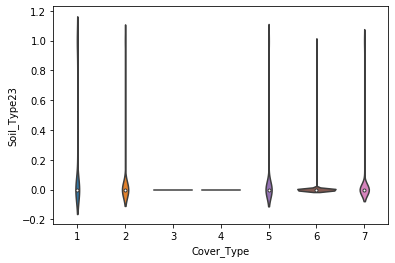

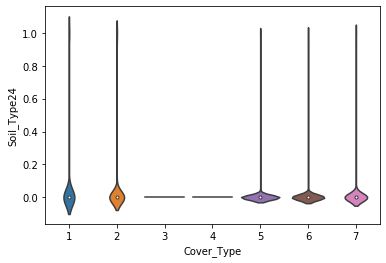

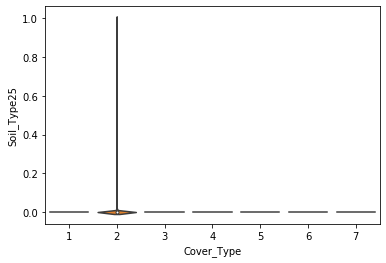

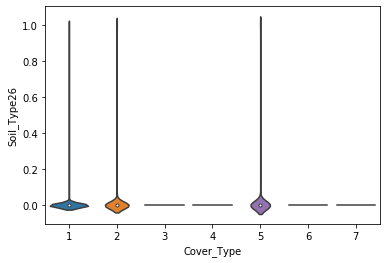

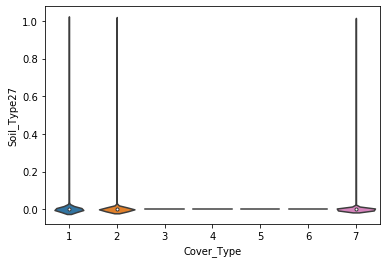

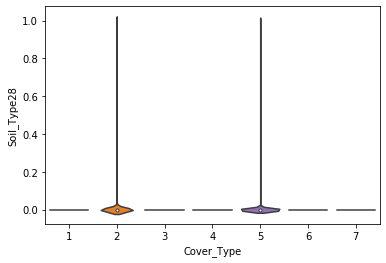

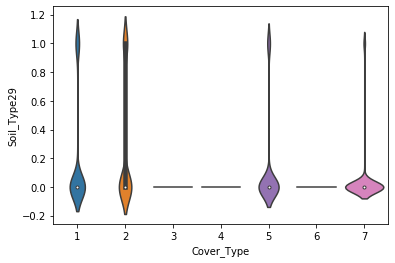

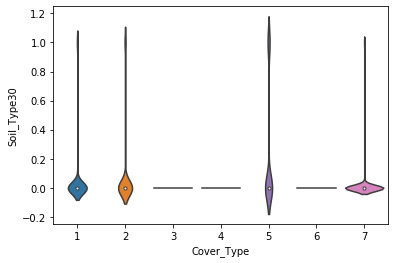

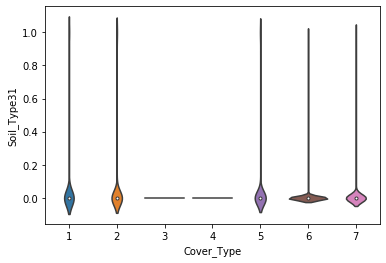

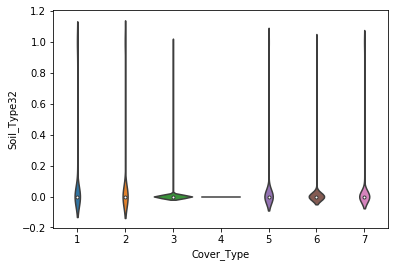

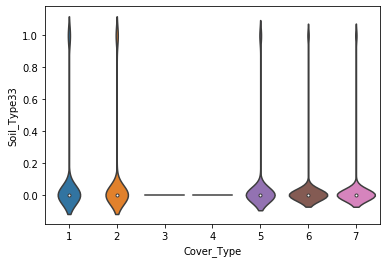

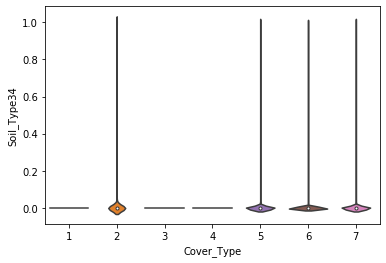

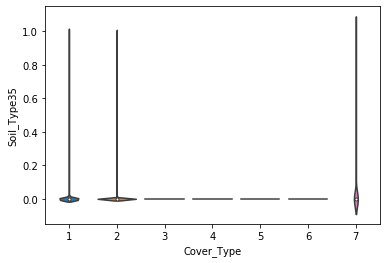

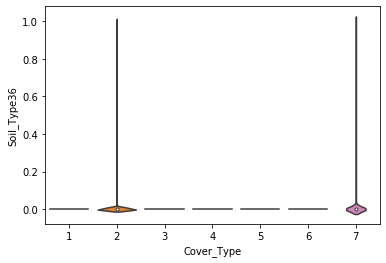

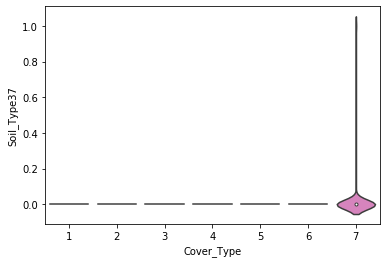

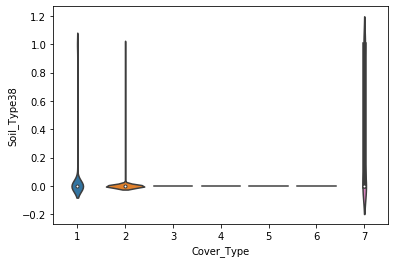

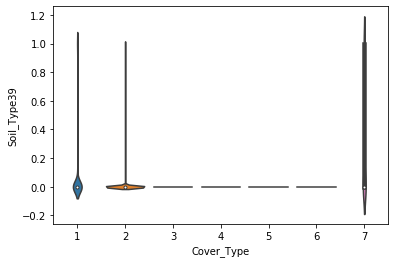

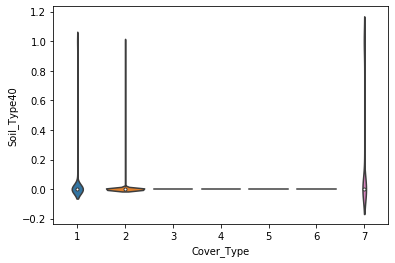

In [81]:
# visualize all the attributes using Violin Plot - a combination of box and density plots

#names of all the attributes 
cols = dataset.columns

#number of attributes (exclude target)
size = len(cols)-1

#x-axis has target attribute to distinguish between classes
x = cols[size]

#y-axis shows values of an attribute
y = cols[0:size]

#Plot violin for all attributes
for i in range(0,size):
    sns.violinplot(data=dataset,x=x,y=y[i])  
    plt.show()

Elevation has a separate distribution for most classes. Highly correlated with the target and hence an important attribute.
Aspect contains a couple of normal distribution for several classes.
Horizontal distance to road and hydrology have similar distribution.
Hillshade 9am and 12pm display left skew.
Hillshade 3pm is normal.
Lots of 0s in vertical distance to hydrology.
Wilderness_Area3 gives no class distinction. As values are not present, others gives some scope to distinguish
Soil_Type, 1,5,8,9,12,14,18-22, 25-30 and 35-40 offer class distinction as values are not present for many classes.

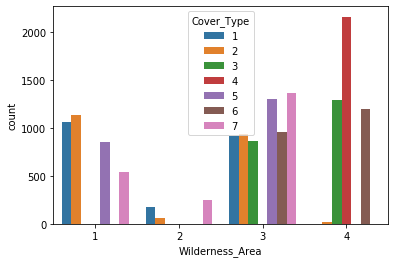

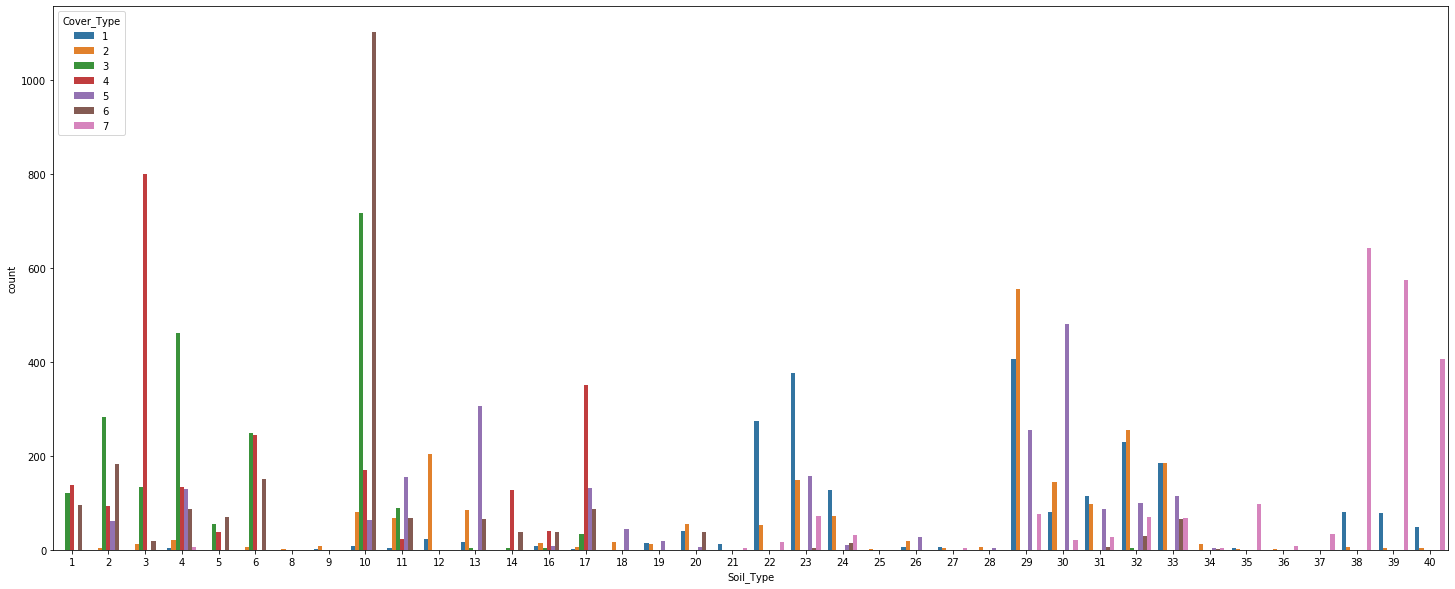

In [82]:
# Group one-hot encoded variables of a category into one single variable

# names of all the columns
cols = dataset.columns

# number of rows=r , number of columns=c
r,c = dataset.shape

# Create a new dataframe with r rows, one column for each encoded category, and target in the end
data = pd.DataFrame(index=np.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

# Make an entry in 'data' for each r as category_id, target value
for i in range(0,r):
    w = 0;
    s = 0;
    # Category1 range
    for j in range(10,14):
        if (dataset.iloc[i,j] == 1):
            w = j-9  #category class
            break
    # Category2 range        
    for k in range(14,54):
        if (dataset.iloc[i,k] == 1):
            s = k-13 #category class
            break
    # Make an entry in 'data' for each r as category_id, target value        
    data.iloc[i] = [w,s,dataset.iloc[i,c-1]]

# Plot for Category1    
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data)
plt.show()
# Plot for Category2
plt.rc("figure", figsize=(25, 10))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=data)
plt.show()

WildernessArea_4 has a lot of presence for cover_type 4. Good class distinction.
WildernessArea_3 has not much class distinction.
SoilType 1-6,10-14,17, 22-23, 29-33,35,38-40 offer lot of class distinction as counts for some are very high.

# Data Preparation

In [87]:
Forest_data = pd.read_csv("../data/train.csv") 
Forest_data.pop('Id')
Forest_data.pop('Soil_Type7')
Forest_data.pop('Soil_Type15')
print('data set shape:', Forest_data.shape)

Cover_Types = ['1. Spruce/Fir', '2. Lodgepole Pine', '3. Ponderosa Pine', 
               '4. Cottonwood/Willow', '5. Aspen', '6. Douglas-fir', '7. Krummholz']

# Train, dev, test split (60/20/20)
split1 = int(len(Forest_data)* 0.60)
split2 = int(split1 + (len(Forest_data) - split1) / 2)

train_data, train_labels = Forest_data[:split1].drop(columns=['Cover_Type']), Forest_data.Cover_Type[:split1]
dev_data, dev_labels     = Forest_data[split1:split2].drop(columns=['Cover_Type']), Forest_data.Cover_Type[split1:split2]
test_data, test_labels   = Forest_data[split2:].drop(columns=['Cover_Type']), Forest_data.Cover_Type[split2:]

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         Cover_Types)
print('number of features:',   len(train_data.columns))
print('feature names:\n',   list(train_data.columns))

data set shape: (15120, 53)
training label shape: (9072,)
dev label shape: (3024,)
test label shape: (3024,)
labels names: ['1. Spruce/Fir', '2. Lodgepole Pine', '3. Ponderosa Pine', '4. Cottonwood/Willow', '5. Aspen', '6. Douglas-fir', '7. Krummholz']
number of features: 52
feature names:
 ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'So

In [95]:
df = pd.DataFrame(train_csv, columns=[i for i in all_headers])

# k-Nearest Neighbors Baseline

In [88]:
# create a list to store accuracies for each k
accuracies = []
k_values = [1,3,5,7,9]
# Use KNeighborsClassifier to produce a k-nearest neighbor model
for k in k_values:
    # Use KNeighborsClassifier to produce a k-nearest neighbor model
    knn = KNeighborsClassifier(n_neighbors=k)

    # Train the model using the mini training sets
    knn.fit(train_data, train_labels)
    
    predictions = knn.predict(dev_data)
    
    # test_predicted_labels = model.predict(test_data)
    # Evaluate the model and append to the list
    score = metrics.f1_score(dev_labels, predictions, average="weighted")

    print("k={}, f1-score = {:.2f}.".format(k, score * 100))
    accuracies.append(score)
print("\nWhen k={}, the accuracy is best.".format(k_values[accuracies.index(max(accuracies))]))

model_1 = KNeighborsClassifier(n_neighbors=k_values[accuracies.index(max(accuracies))])

# Train the model using the training sets
model_1.fit(train_data, train_labels)
predictions = model_1.predict(dev_data)
print("\nClassification report for k={}".format(k_values[accuracies.index(max(accuracies))]))
print(classification_report(dev_labels, predictions))

k=1, f1-score = 48.94.
k=3, f1-score = 49.17.
k=5, f1-score = 49.28.
k=7, f1-score = 49.48.
k=9, f1-score = 49.29.

When k=7, the accuracy is best.

Classification report for k=7
              precision    recall  f1-score   support

           1       0.39      0.51      0.44       676
           2       0.48      0.48      0.48       562
           3       0.56      0.42      0.48       387
           4       0.14      1.00      0.25        10
           5       0.44      0.86      0.58       221
           6       0.37      0.27      0.31       306
           7       0.76      0.49      0.60       862

    accuracy                           0.49      3024
   macro avg       0.45      0.58      0.45      3024
weighted avg       0.53      0.49      0.49      3024



# Naive Bayes Baseline

ideas from:
https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

https://stackoverflow.com/questions/14274771/choosing-classification-algorithm-to-classify-mix-of-nominal-and-numeric-data?rq=1

https://stackoverflow.com/questions/32707914/different-types-of-features-to-train-naive-bayes-in-python-pandas

handling discrete + continous:
https://www.quora.com/Machine-Learning/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together/answer/Arun-Iyer-1

## Bernoulli Naive Bayes

In [101]:
# Evaluate binary features and continuous features indepedently (Naive assumption means no correlation between features taken into account anyways)

# BernoulliNB (Binary features only)
train_data_binary = train_data.iloc[:,10:]
dev_data_binary = dev_data.iloc[:,10:]

bnb = BernoulliNB(alpha=1)
bnb.fit(train_data_binary, train_labels)
acc_bnb = bnb.score(dev_data_binary, dev_labels)
print("BernoulliNB model accuracy using binary features only:", acc_bnb)

BernoulliNB model accuracy using binary features only: 0.5052910052910053


## Gaussian Naive Bayes

In [104]:
# GaussianNB (Continuous features only)
train_data_cont = train_data.iloc[:,:10]
dev_data_cont= dev_data.iloc[:,:10]

gnb = GaussianNB() 
gnb.fit(train_data_cont, train_labels)
acc_gnb = gnb.score(dev_data_cont, dev_labels)
print("GaussianNB model accuracy using continous features only:", acc_gnb)

GaussianNB model accuracy using continous features only: 0.5360449735449735


In [105]:
gnb.predict_proba(dev_data_cont)

array([[2.11491186e-01, 1.38703595e-02, 3.93964736e-13, ...,
        6.19705476e-10, 2.74782771e-12, 7.74638454e-01],
       [2.50158936e-02, 6.64743502e-03, 2.82333612e-16, ...,
        6.45803889e-12, 1.91715894e-16, 9.68336671e-01],
       [6.83099261e-02, 1.32108699e-02, 6.61268725e-16, ...,
        9.46076206e-11, 1.85489839e-15, 9.18479204e-01],
       ...,
       [1.51253437e-14, 1.74789782e-09, 4.96776463e-01, ...,
        1.30751870e-18, 5.01208724e-01, 1.10758539e-70],
       [4.42626936e-03, 6.33488499e-02, 3.72539797e-02, ...,
        8.67083097e-01, 2.78857742e-02, 1.25945784e-12],
       [1.38626387e-03, 2.61829398e-02, 5.62916563e-02, ...,
        8.74257957e-01, 4.18687400e-02, 4.67000714e-14]])

#### Improvement ideas:

Preprocessing:

1. Rescaling bounded features and standardizing continuous features
2. Feature selection


Modeling:

1. Create new features vector from the class assignment probabilities {np.hstack((bernoulli and gaussian))}. Then run another GaussianNB fit on the new features
2. Create function to calculate merged feature probabilities (product of Bernoulli and Gaussian) since we calculate the Bayes probability independently on a specific features

# Baseline: Logistic Regression

In [66]:
lr = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
model_lr = lr.fit(train_data, train_labels)
predictions_lr = model_lr.predict(dev_data)

lr_score = metrics.f1_score(dev_labels, predictions_lr, average="weighted")
print("The f1-score of the model is", lr_score)

The f1-score of the model is 0.6661790539043638


In [89]:
L2_strengths = [0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000]
for c in L2_strengths:
    model = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
    model.fit(train_data, train_labels)
    test_predicted_labels = model.predict(dev_data)
    print('When C=' + str(c) + ', Logistic Regression Model accuracy: %3.2f f1_score: %3.2f' 
           %(model.score(dev_data, dev_labels), 
             metrics.f1_score(dev_labels, test_predicted_labels, average="weighted")))

When C=0.001, Logistic Regression Model accuracy: 0.53 f1_score: 0.55
When C=0.01, Logistic Regression Model accuracy: 0.59 f1_score: 0.59
When C=0.1, Logistic Regression Model accuracy: 0.63 f1_score: 0.64
When C=0.5, Logistic Regression Model accuracy: 0.62 f1_score: 0.63
When C=1, Logistic Regression Model accuracy: 0.63 f1_score: 0.64
When C=10, Logistic Regression Model accuracy: 0.65 f1_score: 0.66
When C=100, Logistic Regression Model accuracy: 0.61 f1_score: 0.62
When C=1000, Logistic Regression Model accuracy: 0.62 f1_score: 0.63


#### feature selection

In [90]:
# mean of absolute coefficients
print(np.around(abs(model.coef_).mean(axis = 0) ,decimals=2))
# sum of absolute coefficients
print(np.around(abs(model.coef_).sum(axis = 0) ,decimals=1))

[0.01 0.   0.06 0.   0.   0.   0.07 0.05 0.05 0.   1.62 0.   1.24 1.88
 0.77 1.19 1.02 0.69 0.49 0.7  0.03 0.23 0.9  0.45 0.76 0.71 0.37 0.24
 0.76 0.42 0.37 0.84 0.19 0.59 0.74 0.71 0.   0.52 0.   0.15 0.63 0.62
 0.79 0.76 0.87 0.14 0.27 0.08 0.38 1.27 1.18 0.52]
[ 0.   0.   0.4  0.   0.   0.   0.5  0.4  0.4  0.  11.3  0.   8.7 13.2
  5.4  8.3  7.1  4.8  3.4  4.9  0.2  1.6  6.3  3.2  5.3  5.   2.6  1.7
  5.3  3.   2.6  5.9  1.3  4.1  5.2  5.   0.   3.6  0.   1.   4.4  4.3
  5.5  5.3  6.1  1.   1.9  0.5  2.7  8.9  8.2  3.6]


#### Improvement Ideas:

1. Remove the coefficients that have both zeros a their mean and sum of absolute coefficients, and retrain the model.
2. Produce a Logistic Regression model using the L1 regularization strength. Reduce the features to only those have at least one non-zero weight among the catogories.